In [222]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import seaborn as sns
from LabUtils.Utils import mkdirifnotexists

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
from LabData.DataAnalyses.TenK_Trajectories.biological_age.predict_age import modality_name_mapping, \
    work_dir, pred_dir, pred_residuals_fig_dir, load_ranked_residuals, Ys_dir, sm, r2_score, \
    BodyMeasuresLoader, add_text_at_corner, male_color, female_color
colors = {'Male': male_color, 'Female': female_color}

In [224]:
fig_dir = mkdirifnotexists(os.path.join(work_dir, 'figures', 'figure2'))

In [253]:
def get_lowess(x_name):
    pred_col = 'age'
    
    y_df = pd.read_csv(os.path.join(Ys_dir, '%s.csv' % x_name), index_col=0).rename(columns={pred_col: 'true'})
    
    predictions_df = pd.read_csv(os.path.join(pred_dir, '%s_female_equal-age' % x_name, 'cv_predictions_df.csv'), 
                                 index_col=0).rename(columns={pred_col: 'pred'})
    df_female = y_df.join(predictions_df[['pred']]).dropna()
    
    predictions_df = pd.read_csv(os.path.join(pred_dir, '%s_male_equal-age' % x_name, 'cv_predictions_df.csv'), 
                                 index_col=0).rename(columns={pred_col: 'pred'})
    df_male = y_df.join(predictions_df[['pred']]).dropna()
    
    lowess = sm.nonparametric.lowess
    
    male_xvals = np.arange(int(df_male['true'].min()), np.ceil(df_male['true'].max()), 0.2)
#     male_xvals = df_male['true']
    male_yvals = lowess(df_male['pred'], df_male['true'], return_sorted=False, frac=0.33, xvals=male_xvals)
    
    female_xvals = np.arange(int(df_female['true'].min()), np.ceil(df_female['true'].max()), 0.2)
#     female_xvals = df_female['true']
    female_yvals = lowess(df_female['pred'], df_female['true'], return_sorted=False, frac=0.33, xvals=female_xvals)
    
    male_r2_score = r2_score(y_true=df_male['true'], y_pred=df_male['pred'])
    female_r2_score = r2_score(y_true=df_female['true'], y_pred=df_female['pred'])
    
#     male_yvals = (male_yvals - male_yvals.mean()) / male_yvals.std()
#     female_yvals = (female_yvals - female_yvals.mean()) / female_yvals.std()
    
    return male_xvals, male_yvals, female_xvals, female_yvals, male_r2_score, female_r2_score


def real_vs_pred(axes, x_name):
    pred_col = 'age'
    
    y_df = pd.read_csv(os.path.join(Ys_dir, '%s.csv' % x_name), index_col=0).rename(columns={pred_col: 'true'})
    
    predictions_df = pd.read_csv(os.path.join(pred_dir, '%s_female_equal-age' % x_name, 'cv_predictions_df.csv'), 
                                 index_col=0).rename(columns={pred_col: 'pred'})
    df_female = y_df.join(predictions_df[['pred']]).dropna()
    
    predictions_df = pd.read_csv(os.path.join(pred_dir, '%s_male_equal-age' % x_name, 'cv_predictions_df.csv'), 
                                 index_col=0).rename(columns={pred_col: 'pred'})
    df_male = y_df.join(predictions_df[['pred']]).dropna()
    
    lowess = sm.nonparametric.lowess
    
    
    for df, ax, name in zip([df_male, df_female], axes, ['Male', 'Female']):
#     for df, name in zip([df_male, df_female], ['Male', 'Female']):
        
        xvals = np.arange(int(df['true'].min()), np.ceil(df['true'].max()), 0.2)
        yvals = lowess(df['pred'], df['true'], return_sorted=False, frac=0.33, xvals=xvals)
        # plot true vs predicted
        ax.scatter(df['true'], df['pred'], alpha=0.3, color=colors[name])
        ax.plot(xvals, yvals, linewidth=3, color='black')
#         ax.set_xlim(df['true'].min()-1, df['true'].max()+1)
#         ax.set_ylim(df['true'].min()-1, df['true'].max()+1)
        ax.set_xlim(38, 72)
        ax.set_ylim(38, 72)
        ax.set_xticks([40, 50, 60, 70])
        ax.set_yticks([40, 50, 60, 70])
        ax.set_xlabel('Chronological %s' % pred_col, fontsize=15)
        ax.set_ylabel('Predicted %s' % pred_col, fontsize=15)
        ax.set_title('%s' % (modality_name_mapping[x_name]), fontsize=15)
        add_text_at_corner(ax, r'%s $R^2$=%0.2g' % (name, r2_score(y_true=df['true'], 
                                                                   y_pred=df['pred'])), 'top left', fontsize=15)
        ax.tick_params(labelsize=15)
    axes[1].set_yticks([])
    axes[1].set_ylabel('')
#     ax.legend()

    
#     df_male['sex'] = 'male'
#     df_female['sex'] = 'female'
#     df = pd.concat((df_male, df_female), axis=0)
#     sns.jointplot(data=df, x="true", y="pred", hue="sex", kind="kde", ax=ax)

In [252]:
rank_or_z = 'centered' # 'zscore'

def compute_menopause_odds():

    from LabData.DataAnalyses.TenK_Trajectories.biological_age.predict_age import match_on_age
    from statsmodels.discrete.discrete_model import Logit
    from scipy.stats import mannwhitneyu
    from LabData.DataLoaders.HormonalStatusLoader import HormonalStatusLoader
    from LabData.DataAnalyses.TenK_Trajectories.utils import screen_samples_relative_to_research_stage

    bml = BodyMeasuresLoader()
    bml_data_baseline = bml.get_data(study_ids=['10K'], research_stage='baseline')

    hsl = HormonalStatusLoader()
    hsl_data_baseline = hsl.get_data(study_ids=['10K'], research_stage='baseline')
    hsl_data_baseline.df = hsl_data_baseline.df.reset_index()
    hsl_data_baseline.df['Date'] = hsl_data_baseline.df['Date'].astype('datetime64[ns]')
    hsl_data_baseline.df.set_index(['RegistrationCode', 'Date'], inplace=True)
    hsl_data_baseline.df_metadata.index = hsl_data_baseline.df.index


    hsl_data_baseline_screened = screen_samples_relative_to_research_stage(hsl_data_baseline, research_stage='baseline', days_relative_to_date=50, absolute=True)
    is_period_col = 'is_getting_period_ques'

    ba_res = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0)
    ba_res

    ba_menopause_logit_df = pd.DataFrame(index=ba_res.index, columns=['025', 'coef', '975', '025 m', 'coef m', '975 m'])
    ba_menopause_logit_df

    df_baseline = bml_data_baseline.df.reset_index('Date')[['is_getting_period']].replace({'is_getting_period': {'Yes': 1, 'No': 0, 'IUD': None, 'Unknown': None}}).copy()
    df_baseline = df_baseline.join(hsl_data_baseline_screened.df.groupby('RegistrationCode').max().dropna(subset=[is_period_col])[is_period_col]).rename(columns={is_period_col: 'baseline'})
    df_baseline['baseline'].fillna(df_baseline['is_getting_period'], inplace=True)
    df_baseline.dropna(subset=['baseline'], inplace=True)
    df_baseline['const'] = 1
    df_baseline.rename(columns={'baseline': 'menopause'}, inplace=True)
    df_baseline['menopause'] = -1 * df_baseline['menopause'] + 1

    ba_menopause_logit_list = []

    for d in tqdm(ba_res.index):
        ba_df = pd.read_csv(os.path.join(pred_dir, '%s_female_equal-age/residuals.csv' % d), index_col=0)
        df_temp = df_baseline.join(ba_df)[['menopause', 'true', 'residuals %s' % rank_or_z]].dropna().rename(columns={'true': 'age'}).astype(float)
    #     df_temp['age'] = df_temp[['age']].apply(lambda x: (x-x.mean())/x.std())

        gr1, gr2 = match_on_age(df_temp[df_temp['menopause'] == 1]['age'], 
                                df_temp[df_temp['menopause'] == 0]['age'], max_tol=3, min_tol=1e-5, num=7)
        print(mannwhitneyu(gr1, gr2))
        print(gr1.shape)

        df_temp_matched = df_temp.loc[list(gr1.index) + list(gr2.index)]
        for matched, df_t in zip([False, True], [df_temp, df_temp_matched]):

            df_temp_logit = df_t[df_t['age']<60]
    #     sns.histplot(data=df_temp_logit, x='age', hue='menopause')
            model = Logit(df_temp_logit['menopause'], df_temp_logit.drop('menopause', axis=1)).fit()
            t, p = mannwhitneyu(df_temp_logit[df_temp_logit['menopause'] == 0]['age'], df_temp_logit[df_temp_logit['menopause'] == 1]['age'])

            params = model.params
            conf = model.conf_int()
            conf['Odds Ratio'] = params
            conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
            # convert log odds to ORs
            odds = pd.DataFrame(np.exp(conf))
            # check if pvalues are significant
            odds['pvalues'] = model.pvalues
            odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]
            odds['matched'] = matched
            odds['menopause n'] = df_temp_logit['menopause'].sum()
            odds['no menopause n'] = df_temp_logit.shape[0] - df_temp_logit['menopause'].sum()
            odds['age diff pval'] = p
            odds = odds.loc[['residuals %s' % rank_or_z]]
            odds.index = [d]
            ba_menopause_logit_list.append(odds)

    odds = pd.concat(ba_menopause_logit_list)
    odds_matched = odds[odds.matched].sort_values('Odds Ratio', ascending=False)
    return odds_matched

cat_to_exclude = ['diet_questions', 'medical_conditions', 'medications']

def plot_menopause_odds(odds_matched, ax):
    odds_matched = odds_matched.drop(cat_to_exclude).rename(index=modality_name_mapping)
    ci = [odds_matched.iloc[::-1]['Odds Ratio'] - odds_matched.iloc[::-1]['2.5%'].values, 
          odds_matched.iloc[::-1]['97.5%'].values - odds_matched.iloc[::-1]['Odds Ratio']]
    ax.errorbar(x=odds_matched.iloc[::-1]['Odds Ratio'], y=odds_matched.iloc[::-1].index.values, xerr=ci,
                color='black',  capsize=3, linestyle='None', linewidth=1,
                marker="o", markersize=5, mfc="black", mec="black", label='95% CI')
    ax.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Odds Ratio and 95% Confidence Interval', fontsize=15)
#     ax.set_title('Biological age around menopause', fontsize=15)
#     ax.legend()


In [227]:
odds_matched = compute_menopause_odds()

  0%|          | 0/17 [00:00<?, ?it/s]

MannwhitneyuResult(statistic=21929.0, pvalue=0.19332895006090134)
(202,)


  6%|▌         | 1/17 [00:00<00:07,  2.16it/s]

Optimization terminated successfully.
         Current function value: 0.666672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633724
         Iterations 5


 12%|█▏        | 2/17 [00:00<00:05,  2.60it/s]

MannwhitneyuResult(statistic=27269.0, pvalue=0.21267313850376068)
(226,)
Optimization terminated successfully.
         Current function value: 0.685136
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692467
         Iterations 3


 18%|█▊        | 3/17 [00:00<00:04,  2.97it/s]

MannwhitneyuResult(statistic=38498.0, pvalue=0.10952972883856704)
(267,)
Optimization terminated successfully.
         Current function value: 0.689520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690436
         Iterations 4


 24%|██▎       | 4/17 [00:01<00:04,  3.01it/s]

MannwhitneyuResult(statistic=32993.0, pvalue=0.11680077189036758)
(247,)
Optimization terminated successfully.
         Current function value: 0.690087
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691207
         Iterations 4


 29%|██▉       | 5/17 [00:01<00:03,  3.16it/s]

MannwhitneyuResult(statistic=33687.0, pvalue=0.09436440569048157)
(249,)
Optimization terminated successfully.
         Current function value: 0.688422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684867
         Iterations 4


 35%|███▌      | 6/17 [00:01<00:03,  3.25it/s]

MannwhitneyuResult(statistic=18508.5, pvalue=0.24327720673160957)
(186,)
Optimization terminated successfully.
         Current function value: 0.689607
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686794
         Iterations 4


 41%|████      | 7/17 [00:02<00:03,  3.29it/s]

MannwhitneyuResult(statistic=30771.0, pvalue=0.10273139940180755)
(238,)
Optimization terminated successfully.
         Current function value: 0.686719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680132
         Iterations 4
MannwhitneyuResult(statistic=21302.0, pvalue=0.2602810701703828)
(200,)
Optimization terminated successfully.
         Current function value: 0.689465
         Iterations 3


 47%|████▋     | 8/17 [00:02<00:02,  3.74it/s]

Optimization terminated successfully.
         Current function value: 0.690500
         Iterations 4
MannwhitneyuResult(statistic=34491.0, pvalue=0.1771598697792316)
(254,)


 53%|█████▎    | 9/17 [00:02<00:02,  3.92it/s]

Optimization terminated successfully.
         Current function value: 0.688538
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693065
         Iterations 3
MannwhitneyuResult(statistic=21302.0, pvalue=0.2602810701703828)
(200,)
Optimization terminated successfully.
         Current function value: 0.689964
         Iterations 3


 59%|█████▉    | 10/17 [00:02<00:01,  4.16it/s]

Optimization terminated successfully.
         Current function value: 0.691965
         Iterations 3
MannwhitneyuResult(statistic=21302.0, pvalue=0.2602810701703828)
(200,)
Optimization terminated successfully.
         Current function value: 0.687356
         Iterations 4


 65%|██████▍   | 11/17 [00:02<00:01,  4.35it/s]

Optimization terminated successfully.
         Current function value: 0.692447
         Iterations 3
MannwhitneyuResult(statistic=30861.0, pvalue=0.2339123810570647)
(241,)
Optimization terminated successfully.
         Current function value: 0.687315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690100
         Iterations 4


 76%|███████▋  | 13/17 [00:03<00:00,  4.40it/s]

MannwhitneyuResult(statistic=31853.0, pvalue=0.18080389474316216)
(244,)
Optimization terminated successfully.
         Current function value: 0.691735
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691574
         Iterations 3


 82%|████████▏ | 14/17 [00:03<00:00,  4.38it/s]

MannwhitneyuResult(statistic=34176.0, pvalue=0.09974279758892302)
(251,)
Optimization terminated successfully.
         Current function value: 0.686478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673004
         Iterations 4


 88%|████████▊ | 15/17 [00:03<00:00,  4.44it/s]

MannwhitneyuResult(statistic=24946.5, pvalue=0.15474560609250465)
(215,)
Optimization terminated successfully.
         Current function value: 0.687961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691727
         Iterations 3


 94%|█████████▍| 16/17 [00:04<00:00,  3.36it/s]

MannwhitneyuResult(statistic=38498.0, pvalue=0.10952972883856704)
(267,)
Optimization terminated successfully.
         Current function value: 0.689726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688734
         Iterations 4


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]

MannwhitneyuResult(statistic=12883.0, pvalue=0.18985783140909496)
(154,)
Optimization terminated successfully.
         Current function value: 0.691562
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686707
         Iterations 4


In [244]:
odds_matched

,2.5%,97.5%,Odds Ratio,pvalues,significant?,matched,menopause n,no menopause n,age diff pval
immune_system,1.065073,1.424949,1.231939,4.970804e-03,significant,True,249.0,249.0,0.094364
blood_lipids,1.148277,1.297625,1.220669,1.632132e-10,significant,True,202.0,202.0,0.193329
hematopoietic_system,1.100746,1.285858,1.189707,1.183202e-05,significant,True,251.0,251.0,0.099743
renal_function,1.057699,1.225658,1.138586,5.565642e-04,significant,True,238.0,238.0,0.102731
liver,1.008445,1.195259,1.097886,3.124509e-02,significant,True,186.0,186.0,0.243277
medications,1.007375,1.191492,1.095573,3.304329e-02,significant,True,267.0,267.0,0.109530
sleep,1.000454,1.132894,1.064616,4.834960e-02,significant,True,154.0,154.0,0.189858
lifestyle,0.991196,1.133408,1.059919,8.886532e-02,not significant,True,241.0,241.0,0.233912
medical_conditions,0.992059,1.112742,1.050669,9.146458e-02,not significant,True,267.0,267.0,0.109530
diet,0.975245,1.116685,1.043571,2.170448e-01,not significant,True,244.0,244.0,0.180804


In [250]:
from mne.stats import fdr_correction
fdr_correction(odds_matched.drop(cat_to_exclude)['pvalues'], alpha=0.01)

(array([False,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False]),
 array([1.73978129e-02, 2.28498463e-09, 8.28241472e-05, 2.59729962e-03,
        8.74862615e-02, 1.12815738e-01, 1.77730638e-01, 3.03862671e-01,
        2.61046946e-01, 3.44944864e-01, 2.62999571e-01, 3.88955123e-01,
        7.77983967e-01, 4.91473941e-01]))

Text(-0.1, 1.05, 'e')

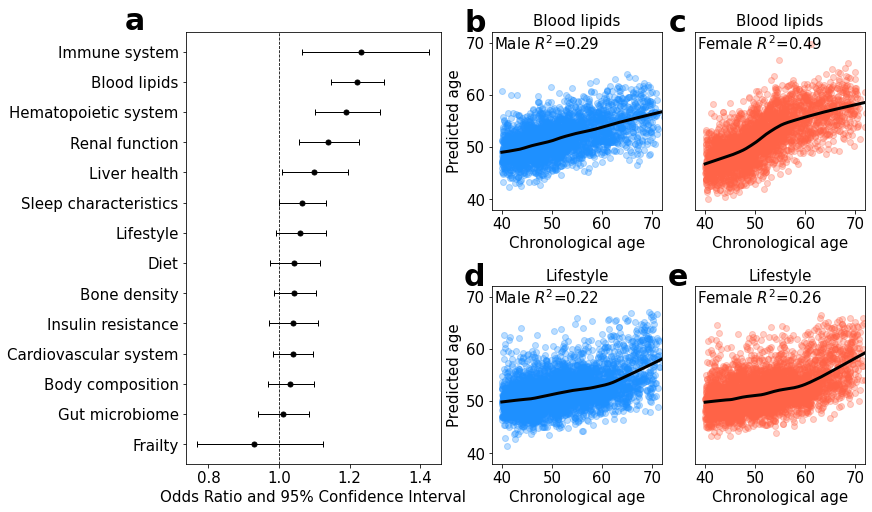

In [254]:
ax_dict = plt.figure(constrained_layout=True, figsize=(12, 7)).subplot_mosaic(
    """
    AAABBCC
    AAADDEE
    """,
    gridspec_kw={"wspace": 0, "hspace": 0},
)

plot_menopause_odds(odds_matched.copy(), ax_dict['A'])
real_vs_pred([ax_dict['B'], ax_dict['C']], x_name='blood_lipids')
real_vs_pred([ax_dict['D'], ax_dict['E']], x_name='lifestyle')

# sex_class_forest_plot(ax_dict['D'], odds_matched)

ax_dict["A"].text(-0.2, 1.025, 'a', ha='center', va='center', transform=ax_dict["A"].transAxes, fontsize=30, weight='bold')
ax_dict["B"].text(-0.1, 1.05, 'b', ha='center', va='center', transform=ax_dict["B"].transAxes, fontsize=30, weight='bold')
ax_dict["C"].text(-0.1, 1.05, 'c', ha='center', va='center', transform=ax_dict["C"].transAxes, fontsize=30, weight='bold')
ax_dict["D"].text(-0.1, 1.05, 'd', ha='center', va='center', transform=ax_dict["D"].transAxes, fontsize=30, weight='bold')
ax_dict["E"].text(-0.1, 1.05, 'e', ha='center', va='center', transform=ax_dict["E"].transAxes, fontsize=30, weight='bold')
# plt.tight_layout()

# plt.savefig(os.path.join(fig_dir, 'figure2.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(fig_dir, 'figure2.pdf'), dpi=300, bbox_inches='tight')

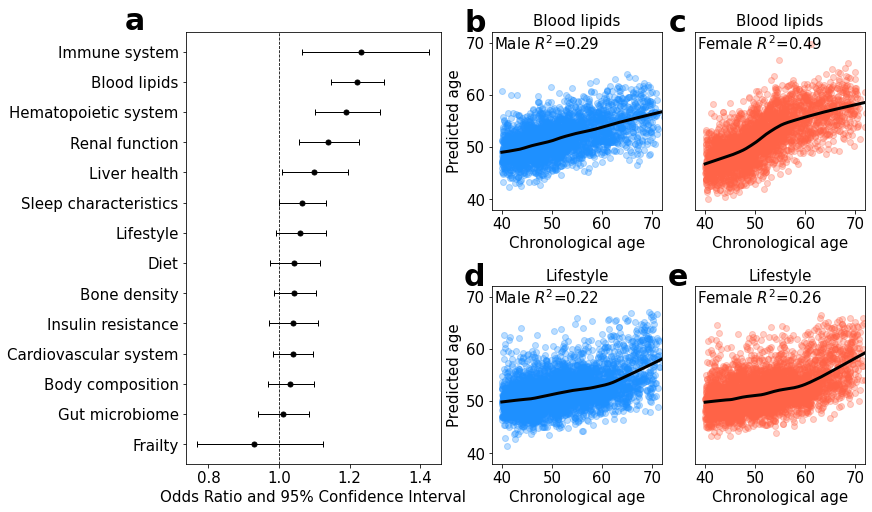

In [256]:
ax_dict = plt.figure(constrained_layout=True, figsize=(12, 7)).subplot_mosaic(
    """
    AAABBCC
    AAADDEE
    """,
    gridspec_kw={"wspace": 0, "hspace": 0},
)

plot_menopause_odds(odds_matched.copy(), ax_dict['A'])
real_vs_pred([ax_dict['B'], ax_dict['C']], x_name='blood_lipids')
real_vs_pred([ax_dict['D'], ax_dict['E']], x_name='lifestyle')

# sex_class_forest_plot(ax_dict['D'], odds_matched)

ax_dict["A"].text(-0.2, 1.025, 'a', ha='center', va='center', transform=ax_dict["A"].transAxes, fontsize=30, weight='bold')
ax_dict["B"].text(-0.1, 1.05, 'b', ha='center', va='center', transform=ax_dict["B"].transAxes, fontsize=30, weight='bold')
ax_dict["C"].text(-0.1, 1.05, 'c', ha='center', va='center', transform=ax_dict["C"].transAxes, fontsize=30, weight='bold')
ax_dict["D"].text(-0.1, 1.05, 'd', ha='center', va='center', transform=ax_dict["D"].transAxes, fontsize=30, weight='bold')
ax_dict["E"].text(-0.1, 1.05, 'e', ha='center', va='center', transform=ax_dict["E"].transAxes, fontsize=30, weight='bold')
# plt.tight_layout()

plt.savefig(os.path.join(fig_dir, 'figure2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure2.pdf'), dpi=300, bbox_inches='tight')

# v2

In [229]:
from scipy.stats import ks_2samp

blood_lipids p=0.00055
blood_lipids p=0.12
cardiovascular_system p=0.94
cardiovascular_system p=1
immune_system p=1.7e-20
immune_system p=0.023
liver p=2.7e-17
liver p=0.0018
renal_function p=3.9e-30
renal_function p=0.042
bone_density p=0.54
bone_density p=0.99
microbiome p=0.097
microbiome p=0.13
body_composition p=0.042
body_composition p=0.31
frailty p=1.8e-10
frailty p=0.0081
lifestyle p=0.79
lifestyle p=0.97
diet p=0.052
diet p=0.19
hematopoietic_system p=3.8e-10
hematopoietic_system p=0.074
glycemic_status p=0.21
glycemic_status p=0.0054
sleep p=2.2e-07
sleep p=0.65


/usr/wisdom/python-3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


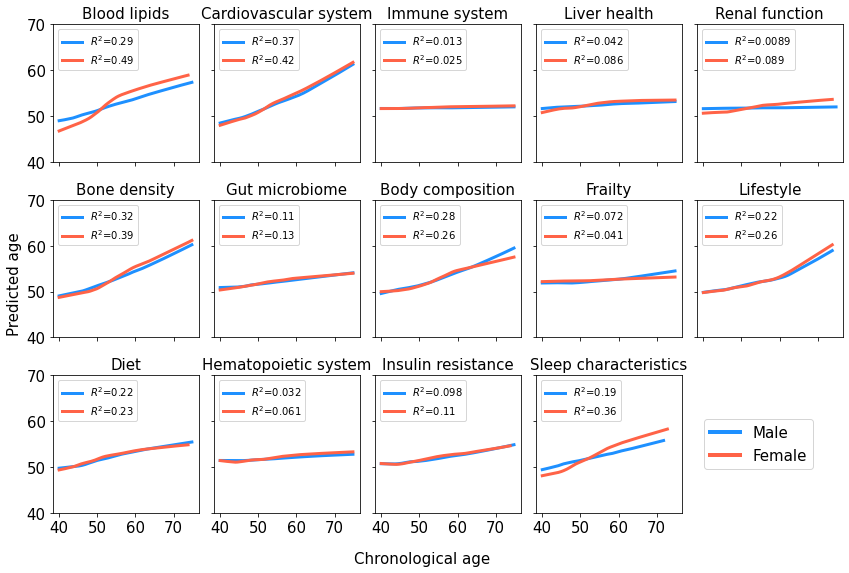

In [242]:
fig, axes = plt.subplots(3, 5, figsize=(12, 8), sharex=True, sharey=True, constrained_layout=True)

x_names = pd.read_csv(os.path.join(pred_dir, 'results.csv'), index_col=0).drop(cat_to_exclude).index
pred_col = 'age'

for x_name, ax in zip(x_names, axes.flatten()):
    male_xvals, male_yvals, female_xvals, female_yvals, male_r2_score, female_r2_score = get_lowess(x_name)
    
    ax.plot(male_xvals, male_yvals, linewidth=3, color=male_color, label=r'$R^2$=%0.2g' % male_r2_score)
    ax.plot(female_xvals, female_yvals, linewidth=3, color=female_color, label=r'$R^2$=%0.2g' % female_r2_score)

    ax.set_xticks([40, 50, 60, 70])
    ax.set_yticks([40, 50, 60, 70])

    ax.set_title('%s' % (modality_name_mapping[x_name]), fontsize=15)
    ax.legend(loc='upper left')
    shorter = min(male_yvals.shape[0], female_yvals.shape[0])
    
    model = LinearRegression().fit(male_yvals[:shorter].reshape(-1, 1), female_yvals[:shorter])
    y_pred = model.predict(male_yvals.reshape(-1, 1))
    
    k, p = ks_2samp(male_yvals, female_yvals)
#     k, p = ks_2samp((male_yvals-male_yvals.mean()) / male_yvals.std(), (female_yvals-female_yvals.mean())/ female_yvals.std())
    print(x_name, 'p=%0.2g' % p)
    
    k, p = ks_2samp(y_pred, female_yvals)
    print(x_name, 'p=%0.2g' % p)

    ax.tick_params(labelsize=15)
ax = axes[-1, -1]
ax.axis('off')
# costume legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=male_color, lw=4),
                Line2D([0], [0], color=female_color, lw=4)]

ax.legend(custom_lines, ['Male', 'Female'], ncol=1, bbox_to_anchor=(0, 0.5), fancybox=True, fontsize=15, loc='center left')
fig.supxlabel('Chronological %s' % pred_col, fontsize=15)
fig.supylabel('Predicted %s' % pred_col, fontsize=15)

fig.tight_layout()

plt.savefig(os.path.join(fig_dir, 'figure2_supp.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_dir, 'figure2_supp.pdf'), dpi=300, bbox_inches='tight')

In [84]:
from sklearn.linear_model import LinearRegression
def fit_lr(x, y):
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    return (abs(y-y_pred)).mean()

def get_lowess(x_name, permute=False):
    pred_col = 'age'
    
    y_df = pd.read_csv(os.path.join(Ys_dir, '%s.csv' % x_name), index_col=0).rename(columns={pred_col: 'true'})
    
    predictions_df = pd.read_csv(os.path.join(pred_dir, '%s_female_equal-age' % x_name, 'cv_predictions_df.csv'), 
                                 index_col=0).rename(columns={pred_col: 'pred'})
    df_female = y_df.join(predictions_df[['pred']]).dropna()
    
    predictions_df = pd.read_csv(os.path.join(pred_dir, '%s_male_equal-age' % x_name, 'cv_predictions_df.csv'), 
                                 index_col=0).rename(columns={pred_col: 'pred'})
    df_male = y_df.join(predictions_df[['pred']]).dropna()
    
    lowess = sm.nonparametric.lowess
    
    if permute:
        xvals = np.arange(int(df_male['true'].min()), np.ceil(df_male['true'].max()), 0.2)
        male_yvals = lowess(df_male['pred'], df_male['true'], return_sorted=False, frac=0.33, xvals=xvals)
        female_yvals = lowess(df_female['pred'], df_female['true'], return_sorted=False, frac=0.33, xvals=xvals)
        male_yvals = (male_yvals-male_yvals.mean()) / male_yvals.std()
        female_yvals = (female_yvals-female_yvals.mean()) / female_yvals.std()
#         real_diff = abs(male_yvals - female_yvals).mean()
        real_diff = fit_lr(male_yvals.reshape(-1, 1), female_yvals)
        print(real_diff)
        df_female['sex'] = 0
        df_male['sex'] = 1
        df_male.loc[:, 'pred'] = df_male[['pred']].apply(lambda x: (x-x.mean()) / x.std())
        df_female.loc[:, 'pred'] = df_female[['pred']].apply(lambda x: (x-x.mean()) / x.std())
        df = pd.concat((df_female, df_male), axis=0)
        
        sum_of_diffs = []
        
        for i in range(permute):
            np.random.seed(i)
            df['sex'] = np.random.permutation(df['sex'].values)
            df_female = df[df['sex'] == 0]
            df_male = df[df['sex'] == 1]
            male_yvals = lowess(df_male['pred'], df_male['true'], return_sorted=False, frac=0.33, xvals=xvals)
            female_yvals = lowess(df_female['pred'], df_female['true'], return_sorted=False, frac=0.33, xvals=xvals)
#             temp_diff = abs(male_yvals - female_yvals).mean()
            male_yvals = (male_yvals-male_yvals.mean()) / male_yvals.std()
            female_yvals = (female_yvals-female_yvals.mean()) / female_yvals.std()
            temp_diff = fit_lr(male_yvals.reshape(-1, 1), female_yvals)
            print(temp_diff)
            sum_of_diffs.append(temp_diff)
            if temp_diff > real_diff:
                return
        return real_diff, sum_of_diffs
            
            
            
    
    
    
    male_xvals = np.arange(int(df_male['true'].min()), np.ceil(df_male['true'].max()), 0.2)
#     male_xvals = df_male['true']
    male_yvals = lowess(df_male['pred'], df_male['true'], return_sorted=False, frac=0.33, xvals=male_xvals)
    
    female_xvals = np.arange(int(df_female['true'].min()), np.ceil(df_female['true'].max()), 0.2)
#     female_xvals = df_female['true']
    female_yvals = lowess(df_female['pred'], df_female['true'], return_sorted=False, frac=0.33, xvals=female_xvals)
    
    male_r2_score = r2_score(y_true=df_male['true'], y_pred=df_male['pred'])
    female_r2_score = r2_score(y_true=df_female['true'], y_pred=df_female['pred'])
    
    return male_xvals, male_yvals, female_xvals, female_yvals, male_r2_score, female_r2_score

In [85]:
real_diff, perm_diff = get_lowess('sleep', 50)
# x_name

0.05569424127114453
0.014623310643333528
0.03473547459453604
0.057825708430039854


TypeError: cannot unpack non-iterable NoneType object

In [100]:
male_xvals, male_yvals, female_xvals, female_yvals, male_r2_score, female_r2_score = get_lowess('immune_system')

In [57]:
np.diff(female_yvals).shape

(169,)

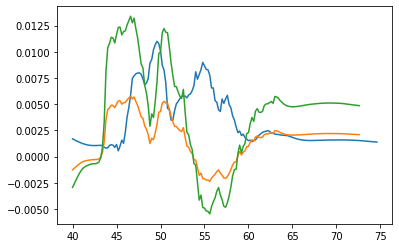

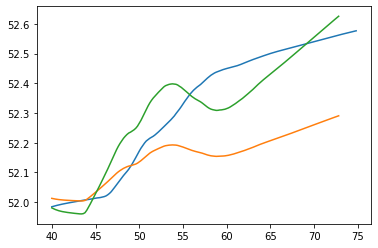

In [101]:
plt.plot(female_xvals[:-1], np.diff(female_yvals))
plt.plot(male_xvals[:-1], np.diff(male_yvals))

model = LinearRegression().fit(male_yvals.reshape(-1, 1), female_yvals[:male_yvals.shape[0]])
y_pred = model.predict(male_yvals.reshape(-1, 1))

plt.plot(male_xvals[:-1], np.diff(y_pred))
plt.show()

plt.plot(female_xvals, female_yvals)
plt.plot(male_xvals, male_yvals)

model = LinearRegression().fit(male_yvals.reshape(-1, 1), female_yvals[:male_yvals.shape[0]])
y_pred = model.predict(male_yvals.reshape(-1, 1))

plt.plot(male_xvals, y_pred)

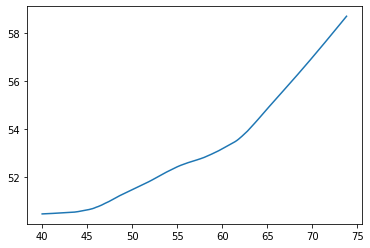

In [88]:
plt.plot(male_xvals, male_yvals)

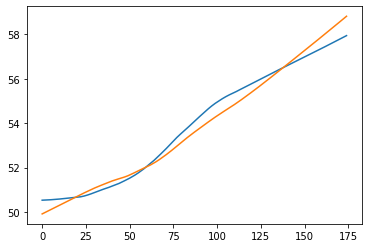

In [23]:
plt.plot(female_yvals)
plt.plot(male_yvals)

In [112]:
def load_real_vs_pred(x_name, sex):
    pred_col = 'age'
    
    y_df = pd.read_csv(os.path.join(Ys_dir, '%s.csv' % x_name), index_col=0).rename(columns={pred_col: 'true'})
    
    predictions_df = pd.read_csv(os.path.join(pred_dir, '%s_%s_equal-age' % (x_name, sex), 'cv_predictions_df.csv'), 
                                 index_col=0).rename(columns={pred_col: 'pred'})
    df = y_df.join(predictions_df[['pred']]).dropna()
    return df

In [188]:
n_bs = 1000
def bs_cov(x):
    res = []
    for i in range(n_bs):
        np.random.seed(i)
        x_temp = np.random.choice(x.stack(), x.shape[0], replace=True)
        res.append(x_temp.std() / x_temp.mean())
    res = pd.Series(res)
    return res.quantile([0.025, 0.5, 0.975])

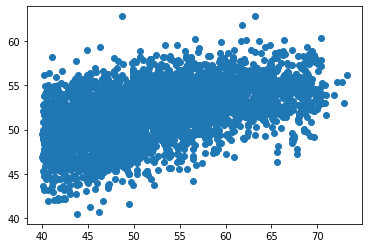

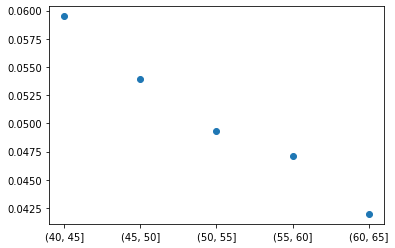

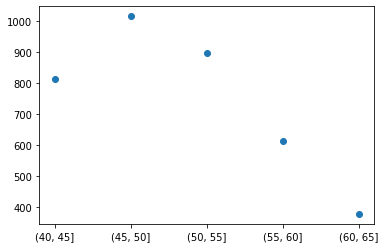

In [189]:
df = load_real_vs_pred('diet', 'female')

plt.scatter(df['true'], df['pred'])
plt.show()
df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 70, 5))
res = df.groupby('age_bin').apply(lambda x: x.std() / x.mean())
count = df.groupby('age_bin').count()
plt.scatter(res.index.astype(str), res['pred'])
plt.show()
plt.scatter(count.index.astype(str), count['pred'])

res = df[['pred', 'age_bin']].groupby('age_bin').apply(lambda x: bs_cov(x))

,age_bin,variable,value
0,"(40, 45]",0.025,0.056808
1,"(45, 50]",0.025,0.051463
2,"(50, 55]",0.025,0.046720
3,"(55, 60]",0.025,0.044421
4,"(60, 65]",0.025,0.038700
5,"(40, 45]",0.5,0.059399
6,"(45, 50]",0.5,0.053869
7,"(50, 55]",0.5,0.049232
8,"(55, 60]",0.5,0.047013
9,"(60, 65]",0.5,0.041809


ValueError: Could not interpret input 'sex'

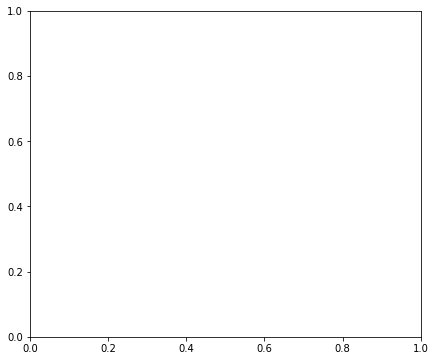

In [200]:
min_max = lambda x: (x.min(), x.max())


df = load_real_vs_pred('diet', 'female')

# plt.scatter(df['true'], df['pred'])
# plt.show()
df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 70, 5))
res = df.groupby('age_bin').apply(lambda x: x.std() / x.mean())
count = df.groupby('age_bin').count()
# plt.scatter(res.index.astype(str), res['pred'])
# plt.show()
# plt.scatter(count.index.astype(str), count['pred'])

res_female = df[['pred', 'age_bin']].groupby('age_bin').apply(lambda x: bs_cov(x))
res_female['sex'] = 'female'



df = load_real_vs_pred('diet', 'male')

# plt.scatter(df['true'], df['pred'])
# plt.show()
df['age_bin'] = pd.cut(df['true'], bins=np.arange(40, 70, 5))
res = df.groupby('age_bin').apply(lambda x: x.std() / x.mean())
count = df.groupby('age_bin').count()
# plt.scatter(res.index.astype(str), res['pred'])
# plt.show()
# plt.scatter(count.index.astype(str), count['pred'])


fig, ax = plt.subplots(1, 1, figsize=(7, 6))

res_male = df[['pred', 'age_bin']].groupby('age_bin').apply(lambda x: bs_cov(x))
res_male['sex'] = 'male'

res = pd.concat((res_male, res_female)).reset_index().melt(id_vars=['age_bin', 'sex'])

sns.pointplot(data=res, x='age_bin', y='value', errorbar=min_max, join=True,
                  dodge=0.7, errwidth=2, ax=ax, hue='sex')

# sns.pointplot(data=res_male.reset_index().melt(id_vars='age_bin'), x='age_bin', y='value', errorbar=min_max, join=True,
#                   dodge=0.7, errwidth=2, ax=ax)

<AxesSubplot:xlabel='age_bin', ylabel='value'>

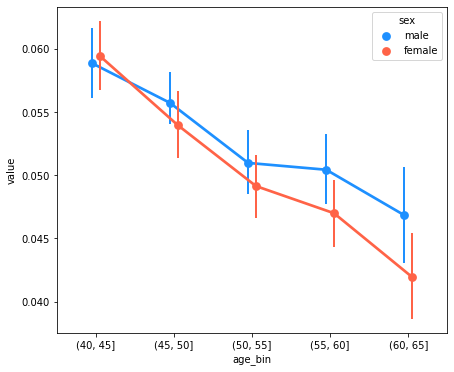

In [221]:
res = pd.concat((res_male, res_female)).reset_index().melt(id_vars=['age_bin', 'sex'])
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.pointplot(data=res, x='age_bin', y='value', hue='sex', errorbar=min_max, join=True,
                  dodge=0.1, errwidth=2, ax=ax, width=0.2, palette=[male_color, female_color])